# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [1]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [2]:
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import FPN
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 30
BATCH_SIZE = 32

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1e-4
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/FPN/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/FPN/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/FPN/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [5]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-5-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.1342, 0.1570, 0.1466,  ..., 0.1619, 0.1616, 0.1712],
         [0.1407, 0.1432, 0.1552,  ..., 0.1647, 0.1659, 0.1755],
         [0.1459, 0.1429, 0.1416,  ..., 0.1638, 0.1684, 0.1712],
         ...,
         [0.2377, 0.2408, 0.2395,  ..., 0.1853, 0.1656, 0.1687],
         [0.2328, 0.2297, 0.2306,  ..., 0.1906, 0.1863, 0.1789],
         [0.2300, 0.2297, 0.2272,  ..., 0.1884, 0.1930, 0.1866]],

        [[0.1523, 0.1836, 0.1671,  ..., 0.1584, 0.1590, 0.1709],
         [0.1546, 0.1651, 0.1769,  ..., 0.1602, 0.1625, 0.1752],
         [0.1570, 0.1590, 0.1616,  ..., 0.1590, 0.1619, 0.1726],
         ...,
         [0.2644, 0.2685, 0.2679,  ..., 0.2045, 0.1822, 0.1848],
         [0.2572, 0.2572, 0.2577,  ..., 0.2071, 0.2039, 0.1946],
         [0.2554, 0.2563, 0.2528,  ..., 0.2056, 0.2100, 0.2027]],

        [[0.1998, 0.2381, 0.2221,  ..., 0.2017, 0.2057, 0.2215],
         [0.2063, 0.2147, 0.2305,  ..., 0.2026, 0.2074, 0.2246],
         [0.2116, 0.2108, 0.2102,  ..., 0.2015, 0.2085, 0.

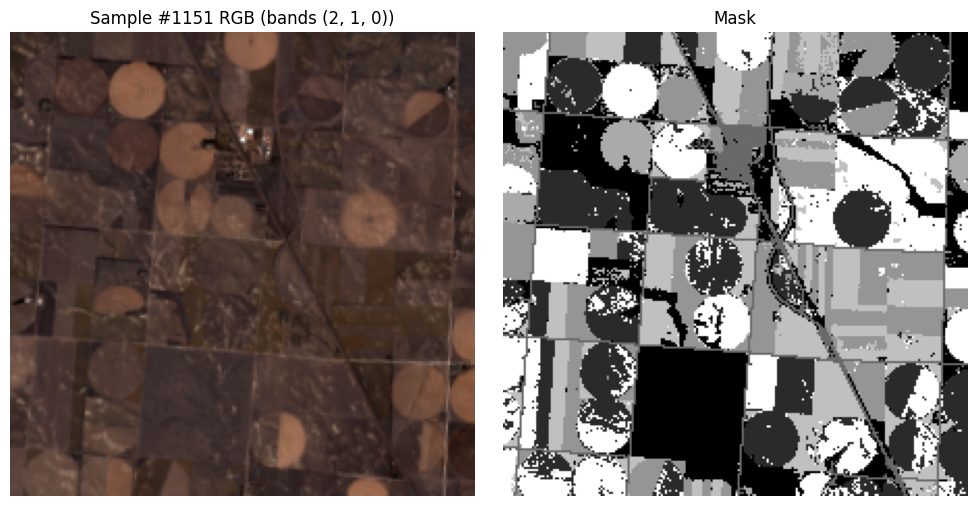

tensor([[[0.1613, 0.1834, 0.2170,  ..., 0.2495, 0.2684, 0.3436],
         [0.1623, 0.1753, 0.2029,  ..., 0.2457, 0.2971, 0.3631],
         [0.1786, 0.1851, 0.1943,  ..., 0.2370, 0.2332, 0.3425],
         ...,
         [0.1488, 0.1521, 0.2538,  ..., 0.4177, 0.4648, 0.3902],
         [0.1650, 0.1521, 0.2587,  ..., 0.3252, 0.4984, 0.3723],
         [0.1726, 0.1466, 0.2229,  ..., 0.2944, 0.2960, 0.2181]],

        [[0.1090, 0.1322, 0.1652,  ..., 0.2139, 0.2487, 0.3629],
         [0.1120, 0.1243, 0.1528,  ..., 0.2131, 0.2742, 0.3805],
         [0.1296, 0.1348, 0.1453,  ..., 0.2011, 0.2213, 0.3820],
         ...,
         [0.1258, 0.1337, 0.2801,  ..., 0.3712, 0.3970, 0.3539],
         [0.1427, 0.1341, 0.2719,  ..., 0.2981, 0.4210, 0.3307],
         [0.1446, 0.1273, 0.2251,  ..., 0.2764, 0.2749, 0.2086]],

        [[0.1209, 0.1483, 0.1948,  ..., 0.2237, 0.2333, 0.3093],
         [0.1212, 0.1357, 0.1767,  ..., 0.2261, 0.2608, 0.3256],
         [0.1441, 0.1519, 0.1700,  ..., 0.2153, 0.2071, 0.

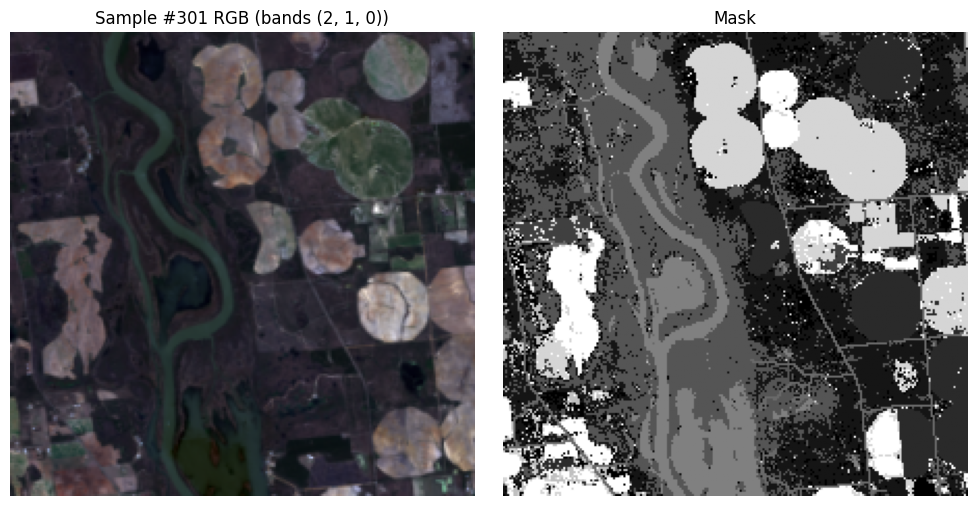

In [6]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [7]:
model = FPN(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

dice_loss = DiceLoss(mode="multiclass", from_logits=True)
focal_loss = FocalLoss(mode="multiclass", gamma=2.0)
ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );


def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    # ensure integer dtype
    targets = targets.long()

    # DiceLoss will internally one-hot `targets`
    L_dice  = dice_loss(preds, targets)
    # FocalLoss expects integer class labels
    L_focal = focal_loss(preds, targets)
    L_ce = ce_loss(preds, targets)

    return 1 * L_ce


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-7-8bc7d79e8e84>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [8]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/30:   0%|          | 0/78 [00:00<?, ?it/s]<ipython-input-5-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/30: 100%|██████████| 78/78 [15:49<00:00, 12.18s/it]


[Epoch  0] Loss:  2.9124, Acc:   0.1321, IoU:   0.0748, Dice:  0.0537, mIoU:  0.0374


Epoch 1/30 [Val]: 100%|██████████| 20/20 [03:09<00:00,  9.48s/it]


[Epoch  0] Loss: 2.0488, Acc: 0.2160, IoU: 0.1181, Dice: 0.0924, mIoU: 0.0692


Epoch 2/30: 100%|██████████| 78/78 [05:58<00:00,  4.60s/it]


[Epoch  1] Loss:  2.3918, Acc:   0.1895, IoU:   0.1141, Dice:  0.0794, mIoU:  0.0591


Epoch 2/30 [Val]: 100%|██████████| 20/20 [01:19<00:00,  3.95s/it]


[Epoch  1] Loss: 1.9364, Acc: 0.2554, IoU: 0.1515, Dice: 0.1142, mIoU: 0.0882


Epoch 3/30: 100%|██████████| 78/78 [05:52<00:00,  4.51s/it]


[Epoch  2] Loss:  2.1440, Acc:   0.2228, IoU:   0.1369, Dice:  0.1004, mIoU:  0.0764


Epoch 3/30 [Val]: 100%|██████████| 20/20 [01:21<00:00,  4.05s/it]


[Epoch  2] Loss: 1.8103, Acc: 0.2938, IoU: 0.1848, Dice: 0.1352, mIoU: 0.1059


Epoch 4/30: 100%|██████████| 78/78 [06:08<00:00,  4.73s/it]


[Epoch  3] Loss:  1.9946, Acc:   0.2495, IoU:   0.1576, Dice:  0.1140, mIoU:  0.0882


Epoch 4/30 [Val]: 100%|██████████| 20/20 [01:49<00:00,  5.45s/it]


[Epoch  3] Loss: 1.7898, Acc: 0.3200, IoU: 0.1962, Dice: 0.1404, mIoU: 0.1108


Epoch 5/30: 100%|██████████| 78/78 [06:24<00:00,  4.93s/it]


[Epoch  4] Loss:  1.8908, Acc:   0.2745, IoU:   0.1753, Dice:  0.1286, mIoU:  0.1008


Epoch 5/30 [Val]: 100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


[Epoch  4] Loss: 1.7575, Acc: 0.2855, IoU: 0.1848, Dice: 0.1422, mIoU: 0.1138


Epoch 6/30: 100%|██████████| 78/78 [06:23<00:00,  4.91s/it]


[Epoch  5] Loss:  1.8200, Acc:   0.3126, IoU:   0.2030, Dice:  0.1399, mIoU:  0.1105


Epoch 6/30 [Val]: 100%|██████████| 20/20 [01:42<00:00,  5.15s/it]


[Epoch  5] Loss: 1.7345, Acc: 0.3399, IoU: 0.2215, Dice: 0.1567, mIoU: 0.1247


Epoch 7/30: 100%|██████████| 78/78 [06:31<00:00,  5.02s/it]


[Epoch  6] Loss:  1.7662, Acc:   0.3303, IoU:   0.2163, Dice:  0.1489, mIoU:  0.1185


Epoch 7/30 [Val]: 100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


[Epoch  6] Loss: 1.6821, Acc: 0.3472, IoU: 0.2303, Dice: 0.1628, mIoU: 0.1319


Epoch 8/30: 100%|██████████| 78/78 [05:12<00:00,  4.00s/it]


[Epoch  7] Loss:  1.7173, Acc:   0.3450, IoU:   0.2278, Dice:  0.1568, mIoU:  0.1257


Epoch 8/30 [Val]: 100%|██████████| 20/20 [01:34<00:00,  4.71s/it]


[Epoch  7] Loss: 1.6430, Acc: 0.3678, IoU: 0.2443, Dice: 0.1708, mIoU: 0.1395


Epoch 9/30: 100%|██████████| 78/78 [05:29<00:00,  4.23s/it]


[Epoch  8] Loss:  1.6756, Acc:   0.3353, IoU:   0.2237, Dice:  0.1657, mIoU:  0.1337


Epoch 9/30 [Val]: 100%|██████████| 20/20 [01:05<00:00,  3.30s/it]


[Epoch  8] Loss: 1.6379, Acc: 0.3923, IoU: 0.2530, Dice: 0.1767, mIoU: 0.1432


Epoch 10/30: 100%|██████████| 78/78 [05:27<00:00,  4.20s/it]


[Epoch  9] Loss:  1.6511, Acc:   0.3712, IoU:   0.2484, Dice:  0.1707, mIoU:  0.1383


Epoch 10/30 [Val]: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


[Epoch  9] Loss: 1.6347, Acc: 0.3550, IoU: 0.2381, Dice: 0.1747, mIoU: 0.1428


Epoch 11/30: 100%|██████████| 78/78 [05:15<00:00,  4.05s/it]


[Epoch 10] Loss:  1.6190, Acc:   0.3821, IoU:   0.2561, Dice:  0.1754, mIoU:  0.1427


Epoch 11/30 [Val]: 100%|██████████| 20/20 [01:24<00:00,  4.23s/it]


[Epoch 10] Loss: 1.6020, Acc: 0.3521, IoU: 0.2403, Dice: 0.1803, mIoU: 0.1479


Epoch 12/30: 100%|██████████| 78/78 [05:47<00:00,  4.46s/it]


[Epoch 11] Loss:  1.6031, Acc:   0.3892, IoU:   0.2627, Dice:  0.1796, mIoU:  0.1466


Epoch 12/30 [Val]: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


[Epoch 11] Loss: 1.6274, Acc: 0.3900, IoU: 0.2538, Dice: 0.1833, mIoU: 0.1484


Epoch 13/30: 100%|██████████| 78/78 [05:55<00:00,  4.55s/it]


[Epoch 12] Loss:  1.5847, Acc:   0.3959, IoU:   0.2673, Dice:  0.1827, mIoU:  0.1498


Epoch 13/30 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.54s/it]


[Epoch 12] Loss: 1.5746, Acc: 0.3778, IoU: 0.2608, Dice: 0.1846, mIoU: 0.1523


Epoch 14/30: 100%|██████████| 78/78 [05:50<00:00,  4.49s/it]


[Epoch 13] Loss:  1.5577, Acc:   0.4076, IoU:   0.2768, Dice:  0.1876, mIoU:  0.1545


Epoch 14/30 [Val]: 100%|██████████| 20/20 [01:06<00:00,  3.34s/it]


[Epoch 13] Loss: 1.5449, Acc: 0.4070, IoU: 0.2785, Dice: 0.1865, mIoU: 0.1548


Epoch 15/30: 100%|██████████| 78/78 [05:27<00:00,  4.20s/it]


[Epoch 14] Loss:  1.5368, Acc:   0.4120, IoU:   0.2810, Dice:  0.1906, mIoU:  0.1572


Epoch 15/30 [Val]: 100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


[Epoch 14] Loss: 1.5228, Acc: 0.4210, IoU: 0.2837, Dice: 0.1937, mIoU: 0.1614


Epoch 16/30: 100%|██████████| 78/78 [05:25<00:00,  4.17s/it]


[Epoch 15] Loss:  1.5215, Acc:   0.4221, IoU:   0.2881, Dice:  0.1945, mIoU:  0.1613


Epoch 16/30 [Val]: 100%|██████████| 20/20 [01:21<00:00,  4.05s/it]


[Epoch 15] Loss: 1.5277, Acc: 0.4169, IoU: 0.2781, Dice: 0.1943, mIoU: 0.1609


Epoch 17/30: 100%|██████████| 78/78 [05:17<00:00,  4.07s/it]


[Epoch 16] Loss:  1.5110, Acc:   0.4257, IoU:   0.2910, Dice:  0.1962, mIoU:  0.1626


Epoch 17/30 [Val]: 100%|██████████| 20/20 [01:34<00:00,  4.72s/it]


[Epoch 16] Loss: 1.5810, Acc: 0.3921, IoU: 0.2623, Dice: 0.1877, mIoU: 0.1544


Epoch 18/30: 100%|██████████| 78/78 [05:53<00:00,  4.53s/it]


[Epoch 17] Loss:  1.4865, Acc:   0.4331, IoU:   0.2973, Dice:  0.2010, mIoU:  0.1673


Epoch 18/30 [Val]: 100%|██████████| 20/20 [01:19<00:00,  3.96s/it]


[Epoch 17] Loss: 1.5105, Acc: 0.3962, IoU: 0.2749, Dice: 0.1998, mIoU: 0.1663


Epoch 19/30: 100%|██████████| 78/78 [05:43<00:00,  4.40s/it]


[Epoch 18] Loss:  1.4678, Acc:   0.4383, IoU:   0.3023, Dice:  0.2035, mIoU:  0.1698


Epoch 19/30 [Val]: 100%|██████████| 20/20 [01:31<00:00,  4.57s/it]


[Epoch 18] Loss: 1.5250, Acc: 0.3952, IoU: 0.2773, Dice: 0.1912, mIoU: 0.1598


Epoch 20/30: 100%|██████████| 78/78 [05:13<00:00,  4.02s/it]


[Epoch 19] Loss:  1.4554, Acc:   0.4446, IoU:   0.3065, Dice:  0.2059, mIoU:  0.1722


Epoch 20/30 [Val]: 100%|██████████| 20/20 [01:09<00:00,  3.47s/it]


[Epoch 19] Loss: 1.4835, Acc: 0.4416, IoU: 0.2964, Dice: 0.2104, mIoU: 0.1754


Epoch 21/30: 100%|██████████| 78/78 [05:20<00:00,  4.11s/it]


[Epoch 20] Loss:  1.4360, Acc:   0.4530, IoU:   0.3131, Dice:  0.2093, mIoU:  0.1755


Epoch 21/30 [Val]: 100%|██████████| 20/20 [01:03<00:00,  3.16s/it]


[Epoch 20] Loss: 1.5065, Acc: 0.4046, IoU: 0.2819, Dice: 0.1995, mIoU: 0.1665


Epoch 22/30: 100%|██████████| 78/78 [05:19<00:00,  4.10s/it]


[Epoch 21] Loss:  1.4470, Acc:   0.4513, IoU:   0.3120, Dice:  0.2097, mIoU:  0.1760


Epoch 22/30 [Val]: 100%|██████████| 20/20 [01:01<00:00,  3.10s/it]


[Epoch 21] Loss: 1.5398, Acc: 0.4295, IoU: 0.2896, Dice: 0.2031, mIoU: 0.1669


Epoch 23/30: 100%|██████████| 78/78 [05:19<00:00,  4.10s/it]


[Epoch 22] Loss:  1.4301, Acc:   0.4569, IoU:   0.3155, Dice:  0.2122, mIoU:  0.1782


Epoch 23/30 [Val]: 100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


[Epoch 22] Loss: 1.5750, Acc: 0.4184, IoU: 0.2776, Dice: 0.2014, mIoU: 0.1663


Epoch 24/30: 100%|██████████| 78/78 [05:45<00:00,  4.43s/it]


[Epoch 23] Loss:  1.4092, Acc:   0.4641, IoU:   0.3232, Dice:  0.2147, mIoU:  0.1811


Epoch 24/30 [Val]: 100%|██████████| 20/20 [01:31<00:00,  4.60s/it]


[Epoch 23] Loss: 1.4753, Acc: 0.4412, IoU: 0.3007, Dice: 0.2093, mIoU: 0.1748


Epoch 25/30: 100%|██████████| 78/78 [05:15<00:00,  4.05s/it]


[Epoch 24] Loss:  1.3899, Acc:   0.4699, IoU:   0.3281, Dice:  0.2183, mIoU:  0.1843


Epoch 25/30 [Val]: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


[Epoch 24] Loss: 1.4972, Acc: 0.4378, IoU: 0.2967, Dice: 0.2081, mIoU: 0.1738


Epoch 26/30: 100%|██████████| 78/78 [06:00<00:00,  4.62s/it]


[Epoch 25] Loss:  1.3793, Acc:   0.4779, IoU:   0.3343, Dice:  0.2204, mIoU:  0.1867


Epoch 26/30 [Val]: 100%|██████████| 20/20 [01:33<00:00,  4.66s/it]


[Epoch 25] Loss: 1.5197, Acc: 0.4108, IoU: 0.2873, Dice: 0.2013, mIoU: 0.1686


Epoch 27/30: 100%|██████████| 78/78 [05:24<00:00,  4.15s/it]


[Epoch 26] Loss:  1.3659, Acc:   0.4845, IoU:   0.3390, Dice:  0.2227, mIoU:  0.1888


Epoch 27/30 [Val]: 100%|██████████| 20/20 [01:29<00:00,  4.47s/it]


[Epoch 26] Loss: 1.5337, Acc: 0.4296, IoU: 0.2870, Dice: 0.2059, mIoU: 0.1701


Epoch 28/30: 100%|██████████| 78/78 [05:13<00:00,  4.01s/it]


[Epoch 27] Loss:  1.3547, Acc:   0.4860, IoU:   0.3406, Dice:  0.2243, mIoU:  0.1904


Epoch 28/30 [Val]: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


[Epoch 27] Loss: 1.4600, Acc: 0.4236, IoU: 0.2923, Dice: 0.2088, mIoU: 0.1764


Epoch 29/30: 100%|██████████| 78/78 [05:46<00:00,  4.44s/it]


[Epoch 28] Loss:  1.3306, Acc:   0.4973, IoU:   0.3501, Dice:  0.2299, mIoU:  0.1962


Epoch 29/30 [Val]: 100%|██████████| 20/20 [01:02<00:00,  3.13s/it]


[Epoch 28] Loss: 1.4524, Acc: 0.4526, IoU: 0.3048, Dice: 0.2121, mIoU: 0.1772


Epoch 30/30: 100%|██████████| 78/78 [05:44<00:00,  4.42s/it]


[Epoch 29] Loss:  1.3185, Acc:   0.5043, IoU:   0.3562, Dice:  0.2319, mIoU:  0.1979


Epoch 30/30 [Val]: 100%|██████████| 20/20 [01:32<00:00,  4.64s/it]

[Epoch 29] Loss: 1.4615, Acc: 0.4378, IoU: 0.3054, Dice: 0.2150, mIoU: 0.1796


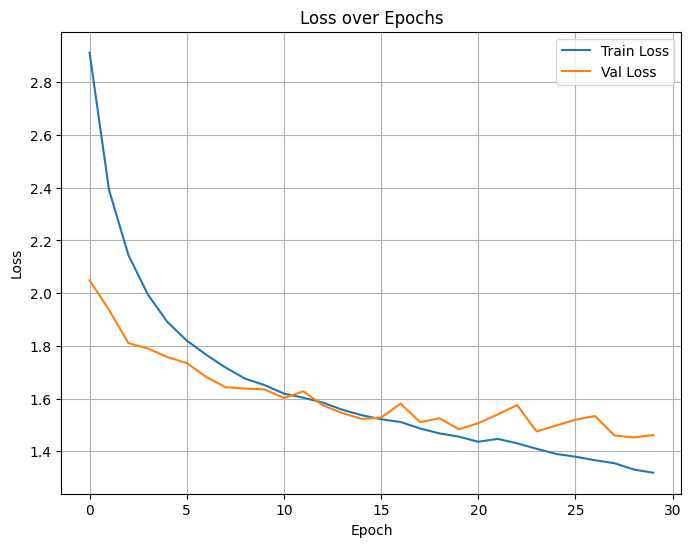

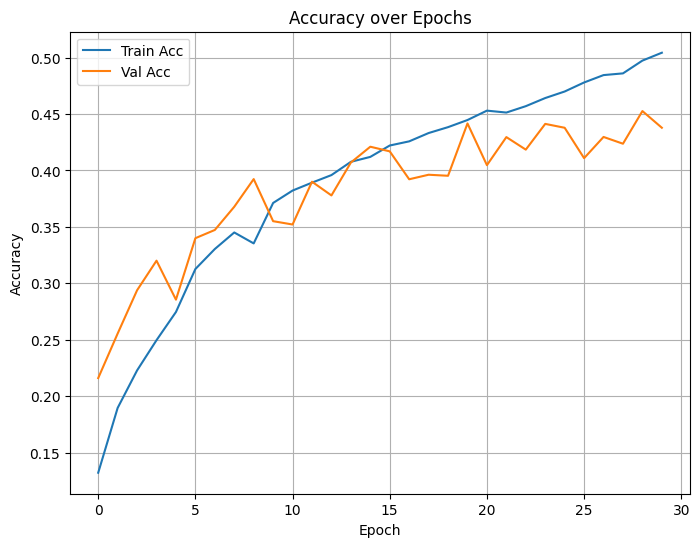

In [9]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(accuracy.compute().item())
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/FPN/graphs/fpn_resnet34_None_32bs_30ep_lr1e-04_loss_20250514-192306_normalized_ce.png


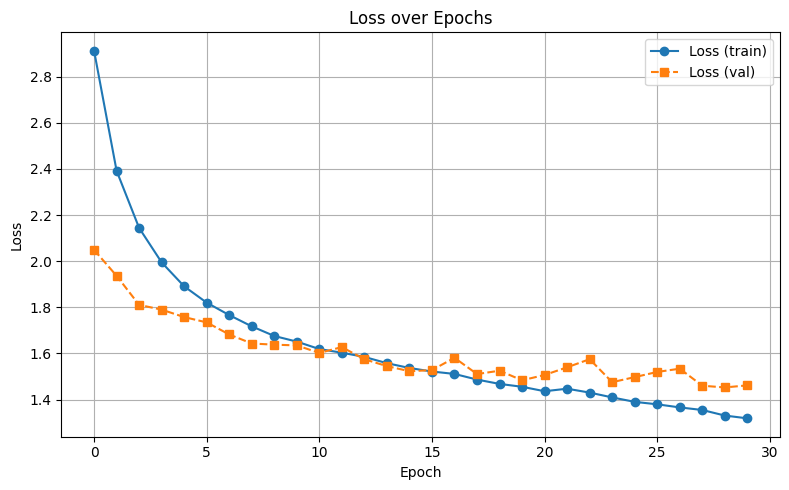

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/FPN/graphs/fpn_resnet34_None_32bs_30ep_lr1e-04_accuracy_20250514-192306_normalized_ce.png


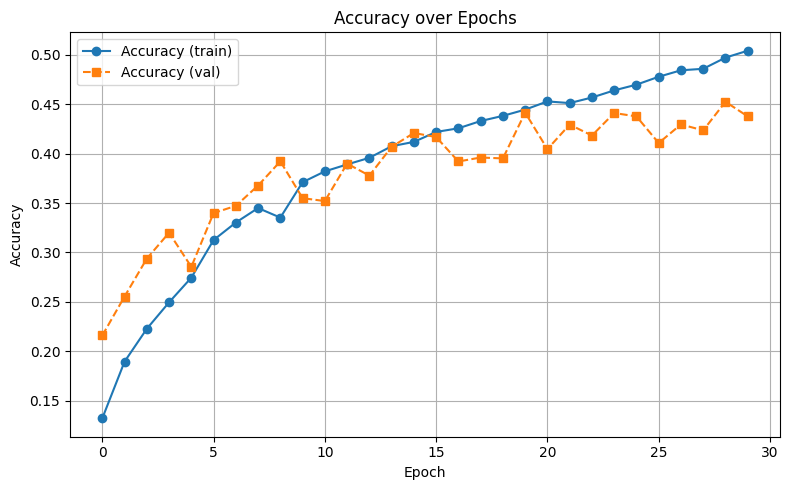

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/FPN/graphs/fpn_resnet34_None_32bs_30ep_lr1e-04_iou_20250514-192306_normalized_ce.png


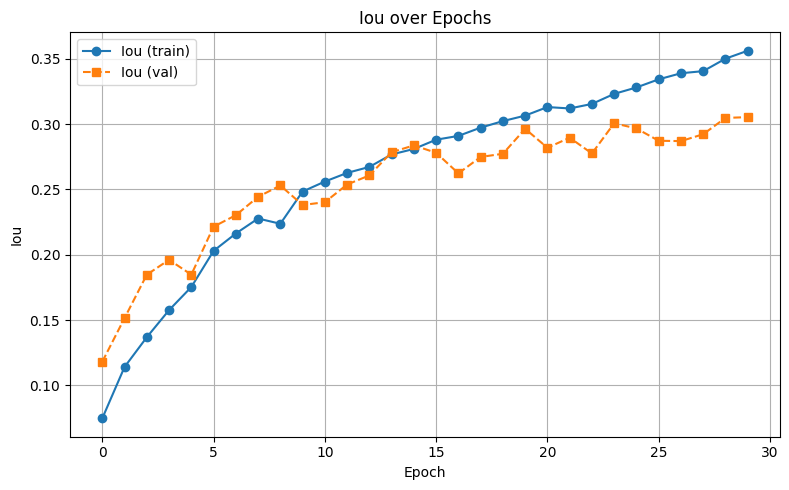

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/FPN/graphs/fpn_resnet34_None_32bs_30ep_lr1e-04_dice_20250514-192306_normalized_ce.png


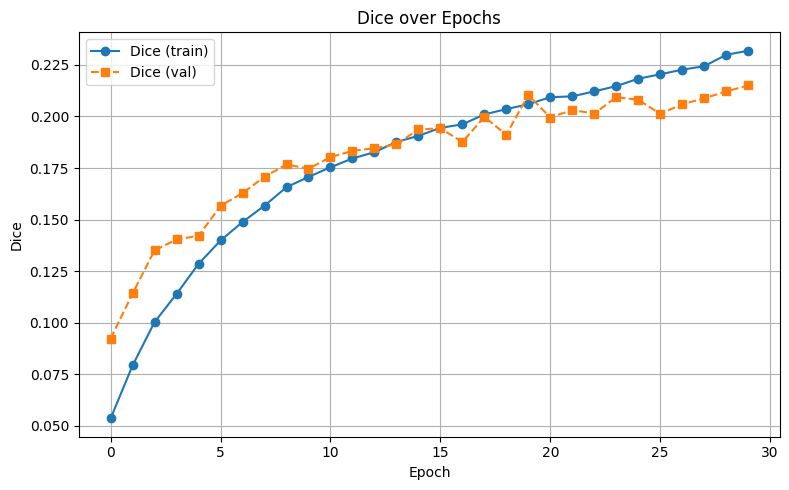

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/FPN/graphs/fpn_resnet34_None_32bs_30ep_lr1e-04_miou_20250514-192306_normalized_ce.png


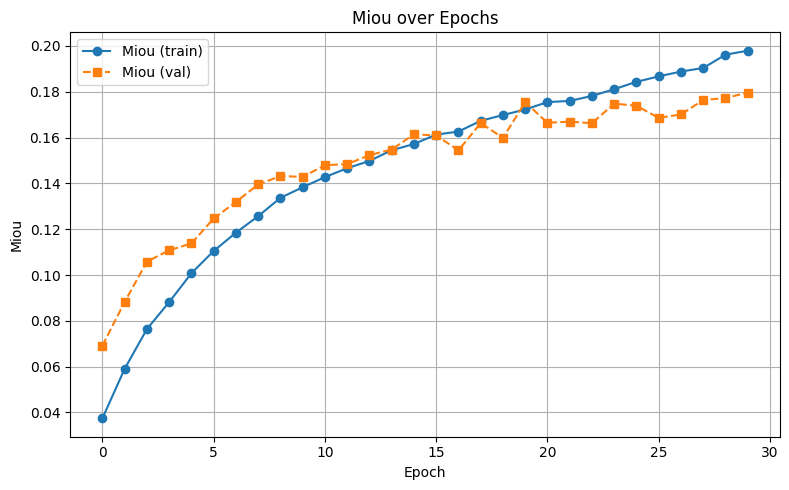

In [10]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"fpn_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_ce.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [11]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"fpn_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_ce.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/FPN/models/fpn_resnet34_None_32bs_30ep_lr1e-04_normalized_ce.pth


In [12]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"fpn_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_ce_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/FPN/metrics/fpn_resnet34_None_32bs_30ep_lr1e-04_normalized_ce_metrics.csv
